# Import Libraries

In [4]:
# !pip install fuzzywuzzy

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# import ydata_profiling as yp
import re
from fuzzywuzzy import process
import fuzzywuzzy
# from rapidfuzz import process, fuzz


import ast

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.impute import KNNImputer as knn

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.simplefilter("ignore")


# Explore Data

In [6]:
data = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')

In [7]:
col_map = {
    'Person Description': 'personDescription',
    'Customer Order': 'customerOrder',
    'Additional Features in market': 'additionalFeaturesInMarket',
    'Promotion Name': 'promotionName',
    'Store Kind': 'storeKind',
    'Store Sales': 'storeSales',
    'Store Cost': 'storeCost',
    'Gross Weight': 'grossWeight',
    'Net Weight': 'netWeight',
    'Package Weight': 'packageWeight',
    'Is Recyclable?': 'isRecyclable?',
    'Yearly Income': 'min.YearlyIncome',
    'Store Area': 'totalArea',
    'Grocery Area': 'groceryArea',
    'Frozen Area': 'frozenArea',
    'Meat Area': 'meatArea',
    'customer_city': 'customer_city',
    'customer_state': 'customer_state',
    'customer_lat': 'customer_lat',
    'customer_lng': 'customer_lng',
    'seller_city': 'seller_city',
    'seller_state': 'seller_state',
    'seller_lat': 'seller_lat',
    'seller_lng': 'seller_lng',
    'review_score': 'review_score'
}

Test = Test.rename(columns=col_map)


In [8]:
data.sample(5)

,personDescription,min.YearlyIncome,customerOrder,grossWeight,netWeight,isRecyclable?,additionalFeaturesInMarket,promotionName,storeKind,storeSales,storeCost,groceryArea,frozenArea,meatArea,cost,customer_city,customer_state,customer_lat,customer_lng,seller_city,seller_state,seller_lat,seller_lng,review_score,totalArea,packageWeight
25150,"Married Female with four kids, education: HS d...",150K+,"Meat from Deli department, Ordered Brand : Lake",11.3235,8.4018,yes,[],Sales Days,SUPERMARKET,1.92 M,0.576 M,2049.72,NaN,303.63,610.5502,fortaleza,CE,-3.780360995008341,-38.54431954524207,sao paulo,SP,-23.539494799586286,-46.63284391414975,5.0,2811.99,2.9216999999999995
18085,"Married Female with one child, education: part...",€25K+,"Vegetables from Frozen Foods department, Order...",11.2944,8.3727,non recyclable,"['Bar For Salad', 'Ready Food']",Super Duper Savers,Supermarket,4.71 Millions,1.7427 Millions,2268.05,853.22,568.75,677.285,canarana,Mt,-13.55856770863092,-52.26752495815682,barretos,SP,-20.5342210194687,-48.56356843130872,4.0,3687.88,2.9216999999999995
29355,"Married Female with one child, education: part...",50K+,"Dairy from Dairy department, Ordered Brand : G...",15.1174,10.7421,yes,"['Coffee Bar', 'Florist', 'Ready Food', 'Bar F...",Promo Big,Gourmet,$1.22 M,0.4636 M,1427.68,465.54,311.59,612.1192,duque de caxias,RJ,data: -22.728162180778853,-43.32198377438596,sao jose dos pinhais,PR,-25.550486998908475,-49.18996687114555,1.0,2201.83,4.375299999999999
24378,"Married Female with two children, education: p...",10K+,"Dairy from Dairy department, Ordered Brand : B...",NaN,28.6358,no,"['Coffee Bar', 'Florist', 'Ready Food', 'Video...",NaN,Deluxe,9.66 M,4.2504 M,1525.28,373.1,248.79,755.9442,sao jose dos campos,SP,-23.27507448002016,-45.889107474000994,SAO PAULO,sP,-23.693985995008337,-46.70188324132953,4.0,NaN,NaN
30294,"Single Male with one child, education: partial...",30000,"Dairy from Dairy department, Ordered Brand : B...",26.8915,22.5307,no,"['Ready Food', 'Bar For Salad', 'Coffee Bar', ...",Save Price,Deluxe,9.99 M,3.7962 M,2057.83,654.13,NaN,584.191,blumenau,SC,-26.91366744240868,-49.075175441023696,belo horizonte,MG,val: -19.840168078827364,amount: -43.92329932223438,5.0,3150.21,4.360800000000001


In [9]:
df = data.copy()

In [10]:
df.size

1081132

In [11]:
df.shape

(41582, 26)

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41582 entries, 0 to 41581
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   personDescription           41552 non-null  object
 1   min.YearlyIncome            41538 non-null  object
 2   customerOrder               41559 non-null  object
 3   grossWeight                 40376 non-null  object
 4   netWeight                   40359 non-null  object
 5   isRecyclable?               41541 non-null  object
 6   additionalFeaturesInMarket  36959 non-null  object
 7   promotionName               35316 non-null  object
 8   storeKind                   35328 non-null  object
 9   storeSales                  41536 non-null  object
 10  storeCost                   41549 non-null  object
 11  groceryArea                 38749 non-null  object
 12  frozenArea                  38826 non-null  object
 13  meatArea                    38773 non-null  ob

In [13]:
df.isna().sum() / len(df) * 100.0

personDescription              0.072147
min.YearlyIncome               0.105815
customerOrder                  0.055312
grossWeight                    2.900293
netWeight                      2.941176
isRecyclable?                  0.098600
additionalFeaturesInMarket    11.117791
promotionName                 15.069020
storeKind                     15.040162
storeSales                     0.110625
storeCost                      0.079361
groceryArea                    6.813044
frozenArea                     6.627868
meatArea                       6.755327
cost                           0.180367
customer_city                  0.069742
customer_state                 0.074551
customer_lat                   0.322255
customer_lng                   0.324660
seller_city                    0.733490
seller_state                   0.755134
seller_lat                     0.848925
seller_lng                     0.858545
review_score                   0.750325
totalArea                      6.760137


In [14]:
df.describe().T

,count,unique,top,freq
personDescription,41552,8107,"Single Male with one child, education: bachelo...",390
min.YearlyIncome,41538,125,30K+,8686
customerOrder,41559,347,"Snack Foods from Snack Foods department, Order...",1001
grossWeight,40376.0,3362.0,20.105021,436.0
netWeight,40359.0,3499.0,17.1814,436.0
isRecyclable?,41541,37,recyclable,11586
additionalFeaturesInMarket,36959,208,['Coffee Bar'],4810
promotionName,35316,106,Save Price,1374
storeKind,35328,2172,Supermarket,8836
storeSales,41536,4992,8.52 Millions,94


In [15]:
df.duplicated().sum()

359

In [16]:
df.drop_duplicates(inplace=True)

In [17]:
# profile = yp.ProfileReport(df, title="My Data")
# profile.to_notebook_iframe()

# Clean Data

In [18]:
df.columns

Index(['personDescription', 'min.YearlyIncome', 'customerOrder', 'grossWeight',
       'netWeight', 'isRecyclable?', 'additionalFeaturesInMarket',
       'promotionName', 'storeKind', 'storeSales', 'storeCost', 'groceryArea',
       'frozenArea', 'meatArea', 'cost', 'customer_city', 'customer_state',
       'customer_lat', 'customer_lng', 'seller_city', 'seller_state',
       'seller_lat', 'seller_lng', 'review_score', 'totalArea',
       'packageWeight'],
      dtype='object')

In [19]:
Test.columns

Index(['ID', 'personDescription', 'customerOrder',
       'additionalFeaturesInMarket', 'promotionName', 'storeKind',
       'storeSales', 'storeCost', 'grossWeight', 'netWeight', 'packageWeight',
       'isRecyclable?', 'min.YearlyIncome', 'totalArea', 'groceryArea',
       'frozenArea', 'meatArea', 'customer_city', 'customer_state',
       'customer_lat', 'customer_lng', 'seller_city', 'seller_state',
       'seller_lat', 'seller_lng', 'review_score'],
      dtype='object')

In [20]:
Test.isna().sum()

ID                               0
personDescription               15
customerOrder                   18
additionalFeaturesInMarket      19
promotionName                   34
storeKind                       49
storeSales                      13
storeCost                       23
grossWeight                    761
netWeight                      825
packageWeight                   15
isRecyclable?                   12
min.YearlyIncome                12
totalArea                     1007
groceryArea                   1060
frozenArea                     978
meatArea                       996
customer_city                   18
customer_state                  13
customer_lat                    56
customer_lng                    70
seller_city                    164
seller_state                   159
seller_lat                     192
seller_lng                     179
review_score                   136
dtype: int64

## `storeKind` column

In [21]:
df['storeKind'].value_counts()

storeKind
Supermarket         8769
Deluxe              7634
Gourmet             2184
SUPERMARKET         1081
supermarket          970
Mid-Size             886
DELUXE               885
deluxe               867
Small Grocery        650
GOURMET              295
gourmet              242
Supermarke7          225
Deluxa               201
Daluxe               200
Supermarket          186
Supermarket_         186
 Supermarket         183
Delux3               180
De1uxe               179
Supermarket\n        178
\tSupermarket        175
D3luxe               169
_Supermarket         164
_Deluxe              159
 Supermarket         154
Deluxe_              154
Deluxe\n             149
 Deluxe              149
 Deluxe              144
\tDeluxe             143
Deluxe               138
DeIuxe               136
mid-size             116
Sup3rmarket          116
Suparmarket          108
Supermarkat          105
Gourme7              101
$upermarket           99
5upermarket           98
MID-SIZE       

In [22]:
df['storeKind'] = df['storeKind'].str.capitalize()
df['storeKind'] = df['storeKind'].str.replace(r'[\t\n_]', '', regex=True)
df['storeKind'] = df['storeKind'].replace(r'1|Tbd|999|To be determined|Nil|[#.-?]+|Missing|Data missing|Not available|Not specified|unknown|Unknown',np.nan , regex=True)


In [23]:
choice = ['deluxe', 'supermarket', 'gourmet', 'midsize', 'small grocery']
for idx, val in df['storeKind'].items():
    if pd.isna(val):
        continue
    best_match = process.extractOne(val, choice)
    if best_match and best_match[1] >= 80:
        df.loc[idx, 'storeKind'] = best_match[0]

In [24]:
df['storeKind'].unique()

array(['deluxe', 'supermarket', nan, 'gourmet', 'midsize',
       'small grocery', '--'], dtype=object)

In [25]:
Test['storeKind'].unique()

array(['Gourmet', 'Deluxe', '_Deluxe', ..., 'MiD-Slze', 'smalL GROCery',
       'SuPArMArkEt'], dtype=object)

In [26]:
df['storeKind'] = df['storeKind'].replace(r'Daluxe|Deiuxe|Deluxa|daluxe', 'deluxe', regex=True)
df['storeKind'] = df['storeKind'].replace(r'--', np.nan, regex=True)

# train['storeKind']=train['storeKind'].fillna('unknown')
df['storeKind'].unique()

array(['deluxe', 'supermarket', nan, 'gourmet', 'midsize',
       'small grocery'], dtype=object)

In [27]:
df['storeKind'].isna().sum()

8482

In [28]:
df['storeKind'].value_counts()

storeKind
supermarket      14189
deluxe           12472
gourmet           3499
midsize           1475
small grocery     1106
Name: count, dtype: int64

In [29]:
Test['storeKind'] = Test['storeKind'].str.capitalize()
Test['storeKind'] = Test['storeKind'].str.replace(r'[\t\n_]', '', regex=True)
Test['storeKind'] = Test['storeKind'].replace(r'1|Tbd|999|To be determined|Nil|[#.-?]+|Missing|Data missing|Not available|Not specified|unknown|Unknown',np.nan , regex=True)



for idx, val in Test['storeKind'].items():
    if pd.isna(val):
        continue
    best_match = process.extractOne(val, choice)
    if best_match and best_match[1] >= 80:
        Test.loc[idx, 'storeKind'] = best_match[0]



Test['storeKind'] = Test['storeKind'].replace(r'Daluxe|Deiuxe|Deluxa|daluxe', 'deluxe', regex=True)
Test['storeKind'] = Test['storeKind'].replace(r'--', np.nan, regex=True)

## `storeSales` an `storeCost` column

In [30]:
df['storeSales'].value_counts()

storeSales
8.52 Millions            91
5.04 Millions            89
7.41 Millions            87
4.8 Millions             87
4.62 Millions            79
€4.1M                    77
5.4 Millions             76
5.22 Millions            76
2.76 Millions            76
7.77 Millions            74
8.88 Millions            72
2.28 Millions            70
7.95 Millions            70
5.04 M                   68
€4.7M                    67
5.52 Millions            67
3.36 Millions            67
2.64 Millions            66
6.84 Millions            66
€4.6M                    65
3.6 Millions             65
11.04 Millions           64
4.26 Millions            64
5.28 Millions            63
€3.1M                    63
€4.4M                    62
3.48 Millions            62
6.72 Millions            62
5.7 Millions             61
4.98 Millions            61
8.85 Millions            61
4.2 Millions             61
4.56 Millions            60
8.1 Millions             60
10.6 Millions            59
5.34 Mill

In [31]:
cols_to_clean = ['storeSales', 'storeCost']


for col in cols_to_clean:

    df[col] = df[col].astype(str)

    df[col] = df[col].str.replace(r'[a-zA-Z()#]+', '', regex=True)
    df[col] = df[col].str.replace(r'\.$', '', regex=True)
    df[col] = df[col].str.replace(r'^[^0-9]', '', regex=True)
    df[col] = df[col].str.replace(r',.*', '', regex=True)


    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col] * 1_000


df.loc[df['storeSales'] > 20_000, 'storeSales'] = np.nan
df.loc[df['storeCost'] > 20_000, 'storeCost'] = np.nan
df.loc[df['storeSales'] < 0, 'storeSales'] = np.nan
df.loc[df['storeCost'] < 0, 'storeCost'] = np.nan

array([[<Axes: title={'center': 'storeSales'}>,
        <Axes: title={'center': 'storeCost'}>]], dtype=object)

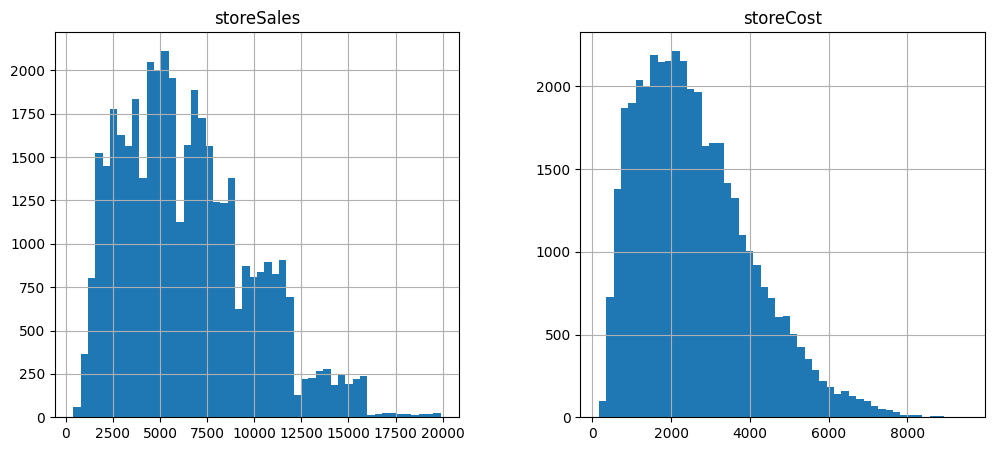

In [32]:
df[cols_to_clean].hist(bins=50, figsize=(12, 5))

In [33]:
cols_to_clean = ['storeSales', 'storeCost']


for col in cols_to_clean:

    Test[col] = Test[col].astype(str)

    Test[col] = Test[col].str.replace(r'[a-zA-Z()#]+', '', regex=True)
    Test[col] = Test[col].str.replace(r'\.$', '', regex=True)
    Test[col] = Test[col].str.replace(r'^[^0-9]', '', regex=True)
    Test[col] = Test[col].str.replace(r',.*', '', regex=True)


    Test[col] = pd.to_numeric(Test[col], errors='coerce')
    Test[col] = Test[col] * 1_000


Test.loc[Test['storeSales'] > 20_000, 'storeSales'] = np.nan
Test.loc[Test['storeCost'] > 20_000, 'storeCost'] = np.nan
Test.loc[Test['storeSales'] < 0, 'storeSales'] = np.nan
Test.loc[Test['storeCost'] < 0, 'storeCost'] = np.nan

## imputing the `storeSales` and `storeCost`  and `storeKind` columns

In [34]:
imputed_cols = ['storeSales', 'storeCost']

imputer = knn(n_neighbors=5)
df[imputed_cols] = imputer.fit_transform(df[imputed_cols])

In [35]:
from scipy.spatial import cKDTree

known = df[df['storeKind'].notna()]
missing = df[df['storeKind'].isna()]

# Build a KD-Tree on numerical columns of known rows
tree = cKDTree(known[['storeSales','storeCost']].values)

# Find the nearest neighbor for each missing row
distances, indices = tree.query(missing[['storeSales','storeCost']].values, k=1)

# Assign the storeKind of nearest neighbor
df.loc[df['storeKind'].isna(), 'storeKind'] = known.iloc[indices]['storeKind'].values

# Check results
print(df['storeKind'].unique())

['deluxe' 'supermarket' 'gourmet' 'midsize' 'small grocery']


In [36]:
df['storeKind'].isna().sum()

0

In [37]:
df['storeKind'].value_counts()

storeKind
supermarket      17919
deluxe           15693
gourmet           4422
midsize           1850
small grocery     1339
Name: count, dtype: int64

## `meatArea`, `groceryArea` ,`frozenArea` ,`totalArea` columns

In [38]:
print(df['meatArea'].isna().sum(), df['groceryArea'].isna().sum(), df['frozenArea'].isna().sum(), df['totalArea'].isna().sum())

2788 2813 2738 2792


In [39]:
Area = ['meatArea','groceryArea','frozenArea','totalArea']

for col in Area:

    # Remove parentheses
    df.loc[df[col].str.contains(r'\(', na=False), col] = df.loc[df[col].str.contains(r'\(', na=False), col].str.strip('()')

    # Remove all non-digit except dot
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Replace negative values with NaN
    df.loc[df[col] < 0, col] = np.nan

In [40]:
print(df['meatArea'].isna().sum(), df['groceryArea'].isna().sum(), df['frozenArea'].isna().sum(), df['totalArea'].isna().sum())

2881 2894 2813 2876


array([[<Axes: title={'center': 'meatArea'}>,
        <Axes: title={'center': 'groceryArea'}>],
       [<Axes: title={'center': 'frozenArea'}>,
        <Axes: title={'center': 'totalArea'}>]], dtype=object)

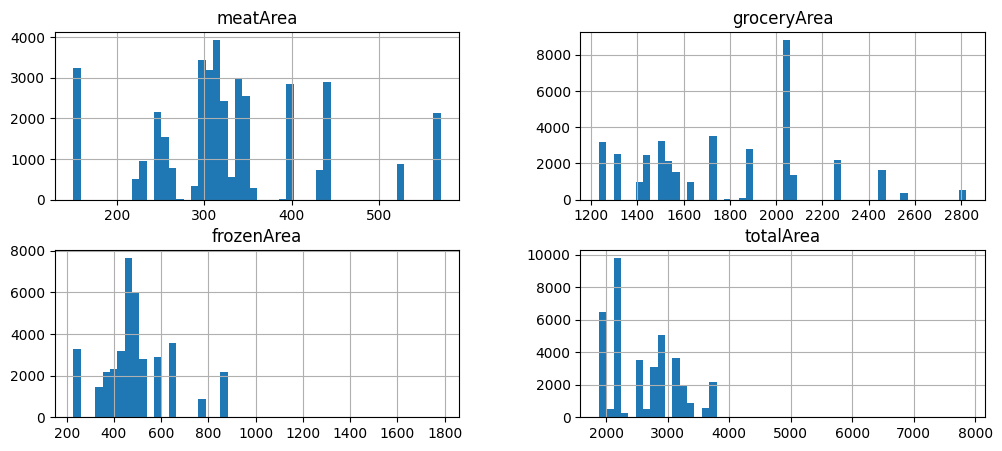

In [41]:
df[Area].hist(bins=50, figsize=(12, 5))

In [42]:
df.loc[df['totalArea'] > 4000, 'totalArea'] = np.nan

In [43]:
df.loc[df['frozenArea'] > 1000, 'frozenArea'] = np.nan

In [44]:
Area = ['meatArea','groceryArea','frozenArea','totalArea']

for col in Area:

    # Remove parentheses
    Test.loc[Test[col].str.contains(r'\(', na=False), col] = Test.loc[Test[col].str.contains(r'\(', na=False), col].str.strip('()')

    # Remove all non-digit except dot
    Test[col] = pd.to_numeric(Test[col], errors='coerce')

    # Replace negative values with NaN
    Test.loc[Test[col] < 0, col] = np.nan


Test.loc[Test['totalArea'] > 4000, 'totalArea'] = np.nan
Test.loc[Test['frozenArea'] > 1000, 'frozenArea'] = np.nan

## filling the Area Columns

In [45]:
imputer = knn(n_neighbors=5)
df[Area] = imputer.fit_transform(df[Area])

In [46]:
print(df['meatArea'].isna().sum(), df['groceryArea'].isna().sum(), df['frozenArea'].isna().sum(), df['totalArea'].isna().sum())

0 0 0 0


## `CustomerOrder` column

In [47]:
df['customerOrder'] = df['customerOrder'].str.lower()

# Extract item before ' from'
df['item'] = df['customerOrder'].str.extract(r'(\w+)\s+from')

# Extract department before ' department'
df['department'] = df['customerOrder'].str.extract(r'(\w+)\s+department')

# Extract brand after 'ordered brand : '
df['order_brand'] = df['customerOrder'].str.extract(r'ordered brand\s*:\s*(\w+)')

In [48]:
df['customerOrder'].isna().sum()
df=df.drop(columns=['customerOrder'])

In [49]:
print(df['item'].isna().sum(), df['department'].isna().sum(), df['order_brand'].isna().sum())

117 117 117


In [50]:
print(len(df['item'].unique()), len(df['department'].unique()), len(df['order_brand'].unique()))

38 17 107


In [51]:
value_counts = df['order_brand'].value_counts()


rare_categories = value_counts[value_counts < 100].index


df['order_brand'] = df['order_brand'].replace(rare_categories, "Unknown")


print(df['order_brand'].value_counts())

order_brand
high            1968
hermanos        1277
red             1231
ebony           1222
Unknown         1222
tell            1187
tri             1115
horatio          994
best             976
nationeel        962
big              956
fast             947
sunset           946
fort             934
carrington       859
golden           825
denny            809
pigtail          804
cormorant        802
imagine          797
bbb              790
super            742
plato            727
landslide        723
blue             670
better           642
cdr              629
just             582
pleasant         557
carlson          557
bravo            553
hilltop          550
even             541
steady           535
club             511
bird             510
consolidated     481
faux             481
booker           478
gorilla          472
moms             440
lake             377
american         364
cutting          361
fabulous         313
excellent        307
fantastic        297
t

In [52]:
col_to_Fill_missing= ['item','department','order_brand']

for i in col_to_Fill_missing :
    df[i]=df[i].fillna('Unknown')

In [53]:
Test['customerOrder'] = Test['customerOrder'].str.lower()
Test['item'] = Test['customerOrder'].str.extract(r'(\w+)\s+from')
Test['department'] = Test['customerOrder'].str.extract(r'(\w+)\s+department')
Test['order_brand'] = Test['customerOrder'].str.extract(r'ordered brand\s*:\s*(\w+)')


Test = Test.drop(columns=['customerOrder'])

## `cost` column

In [54]:
df['cost'].value_counts()

cost
532.6232             508
364.1649             467
313.0678             424
427.7617             423
484.1411             369
689.3663             355
662.2226             332
500.7202             324
477.3944             318
519.7574             312
282.9953             299
343.611              295
516.7763             292
610.5502             289
363.3281             289
455.3761             283
767.3456             278
602.7575             277
419.9167             273
453.9117             257
619.0228             252
755.9442             252
779.6884             239
725.9763             234
735.1811             229
584.191              228
267.3576             225
449.1524             223
656.2604             223
697.7866             222
349.2594             218
364.2695             215
754.7413             211
777.2826             202
670.486              201
773.0986             201
727.9637             198
675.716              196
474.0995             196
406.4756            

In [55]:
# Replace 'missing values' with np.nan
df["cost"] = df["cost"].replace("missing values", np.nan)

# Extract numeric part if present
df["cost"] = df["cost"].astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]

df["cost"] = pd.to_numeric(df["cost"], errors="coerce")


In [56]:
df["cost"].isnull().sum()

138

In [57]:
df["cost"]=df["cost"].astype(float).round(3)

In [58]:
df["cost"].sample(5)

23549    554.903
7414     521.797
32632    670.486
39492    416.256
37211    300.830
Name: cost, dtype: float64

<Axes: >

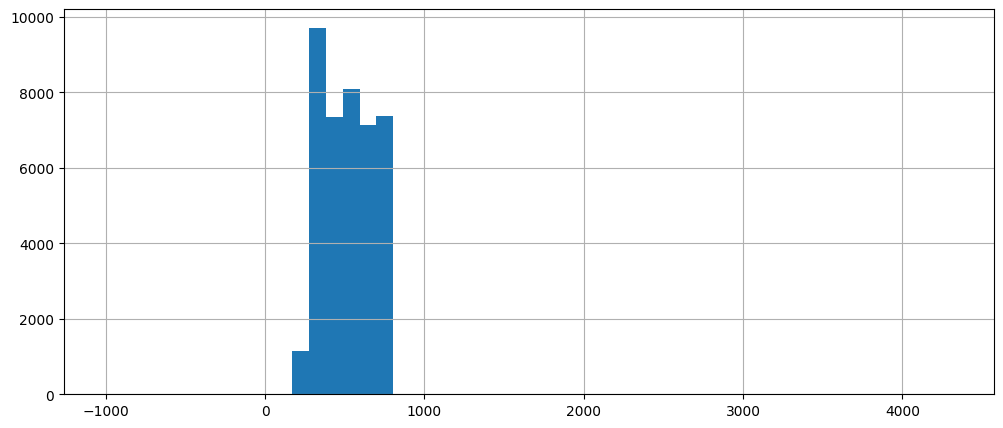

In [59]:
df['cost'].hist(bins=50, figsize=(12, 5))

In [60]:
df.loc[df['cost'] < 0, 'cost'] = np.nan

In [61]:
df.loc[df['cost'] > 1000, 'cost'] = np.nan

<Axes: >

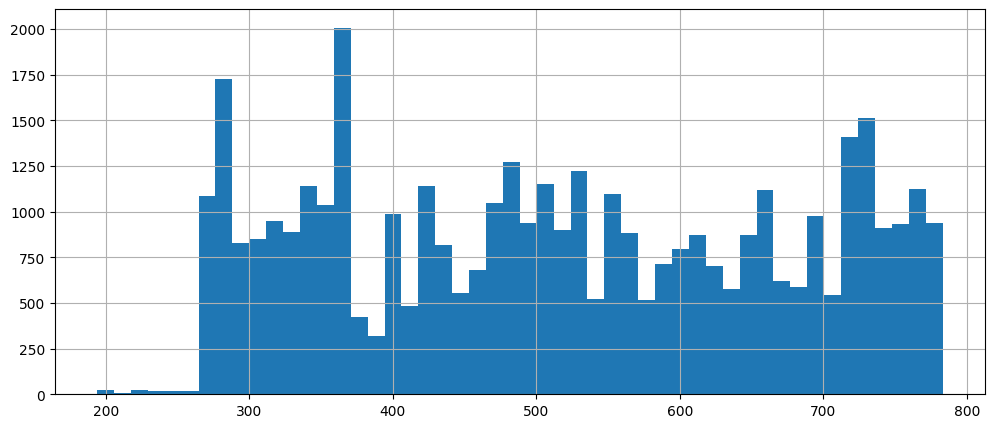

In [62]:
df['cost'].hist(bins=50, figsize=(12, 5))

In [63]:
df['cost'].fillna(df['cost'].median(), inplace=True)

<Axes: >

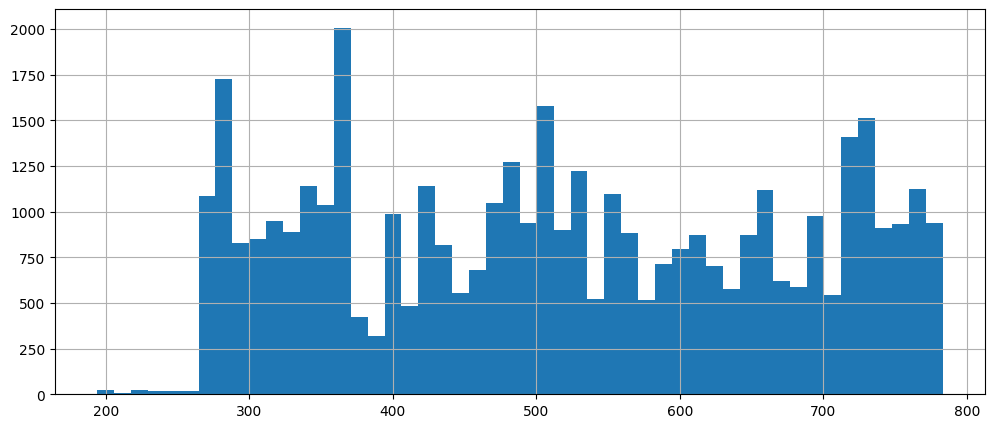

In [64]:
df['cost'].hist(bins=50, figsize=(12, 5))

## `additionalFeaturesInMarket` column

In [65]:
df['additionalFeaturesInMarket'].isna().sum()

4618

In [66]:
def to_list(x):
    if pd.isna(x) or x == "Missing value" or x is '...':
        return np.nan
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    if isinstance(x, list):
        return x

df["additionalFeaturesInMarket"] = df["additionalFeaturesInMarket"].apply(to_list)

In [67]:
df["count_additional_features"] = df["additionalFeaturesInMarket"].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [68]:
df['count_additional_features'].isna().sum()

4644

In [69]:
df.drop(columns=['additionalFeaturesInMarket'], inplace=True)

In [70]:
df['count_additional_features'].value_counts()

count_additional_features
5.0    14609
1.0     7586
4.0     5459
0.0     4488
2.0     4437
Name: count, dtype: int64

In [71]:
imputer = knn(n_neighbors=5)
df['count_additional_features'] = np.round(imputer.fit_transform(df[['count_additional_features']]))

In [72]:
Test["additionalFeaturesInMarket"] = Test["additionalFeaturesInMarket"].apply(to_list)


Test["count_additional_features"] = Test["additionalFeaturesInMarket"].apply(lambda x: len(x) if isinstance(x, list) else np.nan)


Test.drop(columns=['additionalFeaturesInMarket'], inplace=True)

## `seller_city` column

In [73]:
df["seller_city"].value_counts()

seller_city
sao paulo                                 5436
ibitinga                                  1266
SAO PAULO                                  696
curitiba                                   605
Sao Paulo                                  591
belo horizonte                             573
santo andre                                548
guarulhos                                  507
rio de janeiro                             506
ribeirao preto                             486
maringa                                    438
sao jose do rio preto                      415
piracicaba                                 334
campinas                                   305
guariba                                    286
itaquaquecetuba                            269
praia grande                               265
sao bernardo do campo                      256
salto                                      252
campo limpo paulista                       222
jacarei                                    196
l

lets drop and back again

In [74]:
df.drop(columns=['seller_city'], inplace=True)

In [75]:
Test.drop(columns=['seller_city'], inplace=True)

## `seller_state` column

In [76]:
df['seller_state'].isna().sum()

311

In [77]:
df['seller_state'].value_counts()

seller_state
SP                  16994
sp                   2410
Sp                   2361
MG                   2170
PR                   2096
$P                   1427
5P                   1357
RJ                   1256
SC                    760
RS                    498
sP                    446
SP                    355
_SP                   328
SP\n                  327
Mg                    324
mg                    315
 SP                   315
 SP                   304
\tSP                  304
Pr                    294
pr                    292
SP_                   290
DF                    236
5p                    210
$p                    193
Rj                    191
rj                    148
BA                    144
GO                    121
Sc                    117
sc                    109
PE                     95
5C                     78
Rs                     75
$C                     71
ES                     69
rs                     68
MA                     64

In [78]:
# ! pip install rapidfuzz

In [79]:
from rapidfuzz import process as proces
from rapidfuzz import fuzz as fuz

def clean_seller_state(state_series, min_score=60):
    """
    Clean and standardize seller state values using fuzzy matching.

    Parameters:
    -----------
    state_series : pandas Series
        The series containing state values to clean
    min_score : int, default=60
        Minimum fuzzy matching score to accept a match

    Returns:
    --------
    pandas Series
        Cleaned and standardized state values
    """

    # Define valid Brazilian states
    valid_states = [
        "AC", "AL", "AP", "AM", "BA", "CE", "DF", "ES", "GO", "MA",
        "MT", "MS", "MG", "PA", "PB", "PR", "PE", "PI", "RJ", "RN",
        "RS", "RO", "RR", "SC", "SP", "SE", "TO"
    ]

    def match_state(value, valid_states, min_score):
        if pd.isna(value):
            return np.nan

        # Convert to string, uppercase, and strip whitespace
        value = str(value).upper().strip()

        # Remove underscores and other non-letter characters (but keep Ç for CE)
        value = re.sub(r"[^A-ZÇ]", "", value)

        if not value or value in ["NIL", "UNKNOWN", "MISSING", "DATA", "NOTSPECIFIED",
                                 "TBD", "TODETERMINED", "NOTAVAILABLE"]:
            return np.nan

        # Fix common character confusions
        value = (value.replace("Ç", "C")
                     .replace("0", "O")
                     .replace("5", "S")
                     .replace("4", "A")
                     .replace("1", "I")
                     .replace("7", "T")
                     .replace("8", "B")
                     .replace("$", "S")
                     .replace("@", "A")
                     .replace("3", "E"))

        # If it's already valid, return directly
        if value in valid_states:
            return value

        # Fuzzy match with valid states
        match, score, _ = proces.extractOne(value, valid_states, scorer=fuz.ratio)

        if score >= min_score:
            return match
        return np.nan

    # Apply the cleaning function to the series
    return state_series.apply(lambda x: match_state(x, valid_states, min_score))

# Usage example:
df["seller_state"] = clean_seller_state(df["seller_state"])

In [80]:
df["seller_state"].isnull().sum()

554

In [81]:
df["seller_state"].value_counts()

seller_state
SP    25174
AP     3617
MG     3250
PR     3243
RJ     1840
SC     1230
RS      762
DF      351
BA      233
AC      199
GO      189
PE      142
ES      110
MA      110
MT       67
CE       45
AM       36
PA       18
MS       16
RN       15
PB       13
RO        4
SE        4
PI        1
Name: count, dtype: int64

In [82]:
df.fillna({'seller_state': 'SP'}, inplace=True)

In [83]:
Test["seller_state"] = clean_seller_state(Test["seller_state"])

## `review_score` column

In [84]:
df["review_score"].isna().sum()

306

In [85]:
df["review_score"].value_counts()

review_score
5.0                 19557
4.0                  6838
1.0                  4066
3.0                  2958
2.0                  1187
val: 5.0              734
data: 5.0             700
measure: 5.0          690
amount: 5.0           688
val: 4.0              255
data: 4.0             246
measure: 4.0          237
amount: 4.0           222
5.0/5.0               154
data: 1.0             154
val: 1.0              149
100%                  149
measure: 1.0          143
amount: 1.0           142
10.0/10               140
5.0 stars             133
Rating: 5.0           130
amount: 3.0           113
measure: 3.0          112
data: 3.0              99
val: 3.0               92
4.0/5.0                50
Rating: 4.0            49
8.0/10                 45
80%                    39
data: 2.0              39
2.0/10                 37
measure: 2.0           37
4.0 stars              37
amount: 2.0            36
val: 2.0               34
3.0/5.0                30
Rating: 1.0            28

In [86]:
def clean_review_score(df, col='review_score'):
    df_clean = df.copy()

    # Convert to string for processing
    df_clean[col] = df_clean[col].astype(str).str.strip()

    # Function to extract numeric score from each value
    def extract_score(value):
        # Handle NaN and invalid values first
        if value in ['nan', 'None', 'NaN', 'NULL', 'null', '']:
            return np.nan

        # Handle known invalid entries
        invalid_values = ['Not Specified', 'Data Missing', '###', 'To Be Determined',
                         'Not Available', 'TBD', '-999', 'nil', '--', '?', 'unknown',
                         'missing', '-1']
        if value in invalid_values:
            return np.nan

        # Extract numeric patterns
        patterns = [
            r'(\d+\.\d+)',  # 5.0, 4.0, etc.
            r'(\d+)%',      # 100%, 80%, etc.
            r'(\d+)/5',     # 4/5, 3/5, etc. (convert to 20-point scale)
            r'(\d+)/10',    # 8/10, 6/10, etc. (convert to 10-point scale)
            r'Rating:\s*(\d+\.?\d*)',  # Rating: 5.0
            r'val:\s*(\d+\.?\d*)',     # val: 5.0
            r'data:\s*(\d+\.?\d*)',    # data: 5.0
            r'measure:\s*(\d+\.?\d*)', # measure: 5.0
            r'amount:\s*(\d+\.?\d*)',  # amount: 5.0
            r'(\d+)\s*stars',          # 5 stars
        ]

        for pattern in patterns:
            match = re.search(pattern, value, re.IGNORECASE)
            if match:
                score = float(match.group(1))

                # Convert percentages to 5-point scale
                if '%' in value:
                    return (score / 20)  # 100% → 5.0, 80% → 4.0, etc.

                # Convert x/10 scale to 5-point scale
                if '/10' in value.lower():
                    return score / 2

                # Convert x/5 scale (if not already decimal)
                if '/5' in value.lower() and score <= 5:
                    return score

                return min(score, 5.0)  # Cap at 5.0

        # If no pattern matched but it's a simple number
        try:
            score = float(value)
            return min(score, 5.0) if score > 0 else np.nan
        except (ValueError, TypeError):
            return np.nan

    # Apply the extraction function
    df_clean[col] = df_clean[col].apply(extract_score)

    # Round to 1 decimal place for consistency
    df_clean[col] = df_clean[col].round(1)

    return df_clean

In [87]:
df = clean_review_score(df, 'review_score')

In [88]:
df["review_score"].isna().sum()

436

In [89]:
df["review_score"].value_counts()

review_score
5.0    23101
4.0     8027
1.0     4801
3.0     3490
2.0     1368
Name: count, dtype: int64

In [90]:
df['review_score'].fillna(5.0, inplace=True)

In [91]:
Test = clean_review_score(Test, 'review_score')

## `customer_city` column

In [92]:
df['customer_city'].value_counts()

customer_city
sao paulo                                    3565
rio de janeiro                               1634
belo horizonte                                613
brasilia                                      452
Sao Paulo                                     432
SAO PAULO                                     430
curitiba                                      345
porto alegre                                  338
salvador                                      307
campinas                                      282
guarulhos                                     262
sao bernardo do campo                         204
santo andre                                   184
RIO DE JANEIRO                                177
niteroi                                       167
recife                                        162
sao jose dos campos                           160
osasco                                        153
Rio De Janeiro                                152
fortaleza                           

In [93]:
df.drop(columns=['customer_city'], inplace=True)

In [94]:
Test.drop(columns=['customer_city'], inplace=True)

## `customer_state`	column

In [95]:
df['customer_state'].isna().sum()

30

In [96]:
df['customer_state'].value_counts()

customer_state
SP                  10126
RJ                   3545
MG                   3153
sp                   1516
PR                   1406
Sp                   1394
RS                   1335
BA                    846
5P                    824
$P                    814
SC                    757
DF                    554
GO                    506
rj                    504
Rj                    479
Mg                    428
mg                    423
PE                    418
ES                    400
CE                    294
sP                    291
PA                    227
 SP                   222
MT                    208
Rs                    207
_SP                   201
pr                    201
SP_                   199
MA                    196
MS                    194
SP                    194
\tSP                  189
rs                    189
 SP                   188
Pr                    187
SP\n                  187
PB                    136
RN                    1

In [97]:
from rapidfuzz import process as proces
from rapidfuzz import fuzz as fuz

def clean_seller_state(state_series, min_score=60):
    """
    Clean and standardize seller state values using fuzzy matching.

    Parameters:
    -----------
    state_series : pandas Series
        The series containing state values to clean
    min_score : int, default=60
        Minimum fuzzy matching score to accept a match

    Returns:
    --------
    pandas Series
        Cleaned and standardized state values
    """

    # Define valid Brazilian states
    valid_states = [
        "AC", "AL", "AP", "AM", "BA", "CE", "DF", "ES", "GO", "MA",
        "MT", "MS", "MG", "PA", "PB", "PR", "PE", "PI", "RJ", "RN",
        "RS", "RO", "RR", "SC", "SP", "SE", "TO"
    ]

    def match_state(value, valid_states, min_score):
        if pd.isna(value):
            return np.nan

        # Convert to string, uppercase, and strip whitespace
        value = str(value).upper().strip()

        # Remove underscores and other non-letter characters (but keep Ç for CE)
        value = re.sub(r"[^A-ZÇ]", "", value)

        if not value or value in ["NIL", "UNKNOWN", "MISSING", "DATA", "NOTSPECIFIED",
                                 "TBD", "TODETERMINED", "NOTAVAILABLE"]:
            return np.nan

        # Fix common character confusions
        value = (value.replace("Ç", "C")
                     .replace("0", "O")
                     .replace("5", "S")
                     .replace("4", "A")
                     .replace("1", "I")
                     .replace("7", "T")
                     .replace("8", "B")
                     .replace("$", "S")
                     .replace("@", "A")
                     .replace("3", "E"))

        # If it's already valid, return directly
        if value in valid_states:
            return value

        # Fuzzy match with valid states
        match, score, _ = proces.extractOne(value, valid_states, scorer=fuz.ratio)

        if score >= min_score:
            return match
        return np.nan

    # Apply the cleaning function to the series
    return state_series.apply(lambda x: match_state(x, valid_states, min_score))

# Usage example:
df["customer_state"] = clean_seller_state(df["customer_state"])

In [98]:
df['customer_state'].value_counts()

customer_state
SP    15155
RJ     5275
MG     4708
PR     2378
AP     2218
RS     1994
BA     1363
SC     1224
DF      839
GO      817
PE      646
ES      644
CE      604
PA      420
MT      341
AC      281
MA      280
MS      279
PB      219
RN      194
PI      182
AM      172
SE      132
AL      124
RO       87
TO       86
RR       22
Name: count, dtype: int64

In [99]:
df['customer_state'].isna().sum()

539

In [100]:
df['customer_state'].fillna('SP', inplace=True)

In [101]:
Test["customer_state"] = clean_seller_state(Test["customer_state"])

## `personalDescription` column need to choose another imputer techniqe

In [102]:
df['personDescription'].isna().sum()

29

In [103]:
df["clean_desc"] = df["personDescription"].str.lower()
df["clean_desc"] = df["clean_desc"].astype(str)
df["clean_desc"] = df["clean_desc"].str.replace(r"[^a-z\s]", " ", regex=True)
df["clean_desc"] = df["clean_desc"].str.replace(r"\s+", " ", regex=True).str.strip()


def fuzzy_extract(text, keywords, threshold=80):
    for word in text.split():
        match = proces.extractOne(word, keywords)
        if match and match[1] >= threshold:
            return match[0]
    return None

marital_keywords = ["single", "married"]
gender_keywords = ["male", "female"]

df["marital_status"] = df["clean_desc"].apply(lambda x: fuzzy_extract(x, marital_keywords))
df["gender"] = df["clean_desc"].apply(lambda x: fuzzy_extract(x, gender_keywords))

In [104]:
df[["marital_status","gender"]].isna().sum()

marital_status    118
gender            118
dtype: int64

In [105]:
df['marital_status'].value_counts()

marital_status
single     20789
married    20316
Name: count, dtype: int64

In [106]:
df['marital_status'].fillna(df['marital_status'].mode()[0], inplace=True)
df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [107]:
df.drop(columns=['personDescription','clean_desc'], inplace=True)

In [108]:
Test["clean_desc"] = Test["personDescription"].str.lower()
Test["clean_desc"] = Test["clean_desc"].astype(str)
Test["clean_desc"] = Test["clean_desc"].str.replace(r"[^a-z\s]", " ", regex=True)
Test["clean_desc"] = Test["clean_desc"].str.replace(r"\s+", " ", regex=True).str.strip()
Test["marital_status"] = Test["clean_desc"].apply(lambda x: fuzzy_extract(x, marital_keywords))
Test["gender"] = Test["clean_desc"].apply(lambda x: fuzzy_extract(x, gender_keywords))



Test.drop(columns=['personDescription','clean_desc'], inplace=True)

## `min.YearIncome` column

In [109]:
df["min.YearlyIncome"].value_counts()

min.YearlyIncome
30K+                8623
10K+                5632
50K+                4650
70K+                3312
130K+               1465
90K+                1230
110K+               1147
30 Thousand          542
150K+                540
360+ monthly         537
$30K+                527
Income: 30K+         513
€25K+                510
30000                505
30K or more          496
30k                  479
30K+ annually        460
$10K+                386
10 Thousand          377
120+ monthly         376
10k                  368
Income: 10K+         353
10000                350
10K+ annually        347
€8K+                 337
10K or more          332
50000                298
$50K+                294
50K+ annually        289
50 Thousand          287
600+ monthly         280
50K or more          265
€42K+                261
50k                  260
Income: 50K+         239
70000                216
€59K+                213
70K+ annually        203
840+ monthly         203
70k     

In [110]:
df['min.YearlyIncome'].isna().sum()

44

In [111]:
def clean_income(value):
    val = str(value).lower().strip()

    # Remove icons
    for r in ["$", "€", "income:", "or more", "annually", "+"]:
        val = val.replace(r, "")
    val = val.strip()

    # لو مكتوب monthly → ضرب ×12
    if "monthly" in val:
        num = "".join([c for c in val if c.isdigit()])
        if num.isdigit():
            return int(num) * 12
        return None

    # لو فيه K → *1000
    if "k" in val:
        num = val.replace("k", "").strip()
        if num.isdigit():
            return int(num) * 1000

    # لو فيه thousand → *1000
    if "thousand" in val:
        num = val.replace("thousand", "").strip()
        if num.isdigit():
            return int(num) * 1000

    # If it was all numbers
    if val.isdigit():
        return int(val)

    return None

df["min.YearlyIncome"] = df["min.YearlyIncome"].apply(clean_income) / 1000  # Convert to thousands


<Axes: >

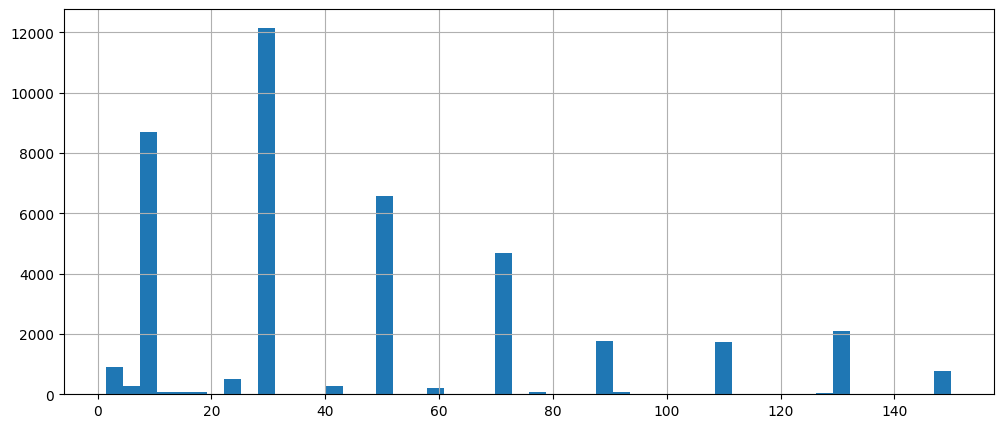

In [112]:
df['min.YearlyIncome'].hist(bins=50, figsize=(12, 5))

In [113]:
df['min.YearlyIncome'].fillna(df['min.YearlyIncome'].median(), inplace=True)

In [114]:
Test["min.YearlyIncome"] = Test["min.YearlyIncome"].apply(clean_income) / 1000  # Convert to thousands

## `isRecyclable?` column

In [115]:
df["isRecyclable?"].value_counts()

isRecyclable?
recyclable          11575
yes                 11256
non recyclable       9166
no                   9060
Data Missing           11
unknown                10
TBD                     8
Not Specified           7
...                     7
-999                    7
-1                      6
missing                 6
no                      5
(yes)                   5
?                       4
Recyclable              4
--                      4
 recyclable             3
yes                     3
 yes                    3
(no)                    3
No                      3
###                     3
To Be Determined        3
recyclable              2
yes.                    2
non recyclable          2
non recyclable.         2
no.                     2
nil                     2
YES                     2
Yes                     1
RECYCLABLE              1
Not Available           1
recyclable.             1
NON RECYCLABLE          1
(recyclable)            1
Name: count, dtype: int6

In [116]:
def clean_recyclable_status(status):
    if pd.isna(status):
        return np.nan

    status = str(status).strip().lower()

    # Yes variations
    if status in ['recyclable', 'yes', 'yes.', '(yes)', 'recyclable.', '(recyclable)',
                 ' recyclable', 'yes ', ' yes', 'recyclable', 'yes']:
        return 'Yes'

    # No variations
    elif status in ['non recyclable', 'no', 'no.', '(no)', 'non recyclable.', 'non recyclable',
                   'no', 'non recyclable', 'No', 'NON RECYCLABLE']:
        return 'No'

    # Missing/Unknown data
    elif status in ['', 'unknown', 'data missing', 'missing', 'tbd', 'to be determined',
                   'not specified', 'not available', '-999', '-1', '?', '--', '###', 'nil',
                   '...']:
        return np.nan

    else:
        return np.nan  # Default for any unexpected values

In [117]:
df['isRecyclable?'] = df['isRecyclable?'].apply(lambda x: clean_recyclable_status(x))

In [118]:
df["isRecyclable?"].value_counts()

isRecyclable?
Yes    22859
No     18244
Name: count, dtype: int64

In [119]:
df['isRecyclable?'].isna().sum()

120

In [120]:
df['isRecyclable?'].fillna('Yes', inplace=True)

In [121]:
Test['isRecyclable?'] = Test['isRecyclable?'].apply(lambda x: clean_recyclable_status(x))

## `promotionName` column the imputing need to be handled by group by or another method

In [122]:
df["promotionName"].value_counts()

promotionName
Save Price                   1365
Weekend Discount             1355
Two Day Sale                 1341
Price Winners                1218
Super Savers                 1150
Save It (Sale)               1131
Super Duper Savers           1115
One Day Sale                 1065
Roller Savings (High)        1048
Sale : Double Down           1031
GLD                          1006
Price Slashers                976
Shelf Clearing Days           963
Full Free                     948
Lottery Cash Registerion      888
Go For It                     866
Two for One                   842
Money Savers                  840
Big Time Discounts            815
Price Destroyers              790
Saving Days                   760
Budget Bargains               754
Discount Frenzy               696
Best Price Savers             695
Dimes Off                     669
Promo Big                     635
You Save Days                 634
Savings Galore                628
Sales Days                    623


In [123]:
df['promotionName'].isna().sum()

6189

In [124]:
def simplify_promotion(name):
    if pd.isna(name):
        return np.nan

    val = str(name).strip().lower()

    # ✅ missing values
    missing_patterns = [
        r"^-\d+$",
        r"^[?.#\-]+$",
        r"\b(unknown|missing|nil|tbd|not available|not specified|to be determined)\b"
    ]
    if any(re.search(pat, val) for pat in missing_patterns):
        return np.nan

    # ✅ categories
    rules = {
        "Time Sale": [
            r"day", r"days", r"weekend", r"mystery", r"dollar"
        ],
        "Quantity Sale": [
            r"two\s*for\s*one", r"three\s*for\s*one", r"double"
        ],
        "Price/Discount": [
            r"save", r"saver", r"saving", r"price", r"discount", r"slash",
           r"smash", r"off", r"bargain", r"deal", r"stuffer", r"big time", r"roller"
        ]
        ,
        "Coupon/Lottery": [
            r"coupon", r"lottery"
        ],
        "Free/Special": [
            r"free", r"special", r"gld", r"go for it", r"shelf emptier", r"cant believe"
        ]
    }

    for category, patterns in rules.items():
        for pat in patterns:
            if re.search(pat, val):
                return category

    return "Other"

df["promoCategory"] = df["promotionName"].apply(simplify_promotion)

In [125]:
df['promoCategory'].isna().sum()

6280

In [126]:
df["promoCategory"].value_counts()

promoCategory
Price/Discount    18014
Time Sale          7378
Free/Special       4137
Quantity Sale      2606
Other              1696
Coupon/Lottery     1112
Name: count, dtype: int64

In [127]:
other_values = df.loc[df["promoCategory"] == "Other", "promotionName"]
print("Top values in 'Other':\n")
other_values.value_counts()

Top values in 'Other':



promotionName
Promo Big         635
Sale Winners      537
Sale Sale Sale    522
 Promo Big          1
Sale Winners        1
Name: count, dtype: int64

In [128]:
df['promoCategory'].fillna(df['promoCategory'].mode()[0], inplace=True)

In [129]:
df.drop(columns=['promotionName'], inplace=True)

In [130]:
Test["promoCategory"] = Test["promotionName"].apply(simplify_promotion)
Test.drop(columns=['promotionName'], inplace=True)

## `grossWeight` column

In [131]:
df["grossWeight"].value_counts()

grossWeight
20.105021             416
24.8564               273
28.9265               269
25.0018               264
21.3678               258
23.4028               246
24.7111               240
27.1822               236
19.9142               234
19.1874               233
16.7163               232
21.0771               231
28.6358               227
31.543                224
30.3801               223
28.0543               222
30.9615               218
26.6008               213
17.8792               213
19.7689               213
19.4781               211
14.972                208
31.6883               208
19.0421               204
30.8162               201
27.0368               201
16.4256               198
23.5482               196
19.6235               195
15.1174               195
15.4081               195
16.8617               194
25.1472               194
31.8337               193
23.9843               191
23.8389               188
17.4431               188
25.2925               183


In [132]:
df['grossWeight'].isna().sum()

1206

In [133]:
def clean_weight(value):
    if pd.isna(value):
        return np.nan

    s = str(value).strip().lower()

    # Missing placeholders
    if s in ["not available", "nil", "?", "unknown", "to be determined", "tbd", "--"]:
        return np.nan

    # Remove "data:", "val:", "amount:", "measure:"
    for prefix in ["data:", "val:", "amount:", "measure:"]:
        if s.startswith(prefix):
            s = s.replace(prefix, "").strip()

    # Handle units
    if "kg" in s:
        return float(s.replace("kg", "").strip())
    elif "grams" in s:
        return float(s.replace("grams", "").strip()) / 1000
    elif "lbs" in s:
        return float(s.replace("lbs", "").strip()) * 0.453592
    elif "oz" in s:
        return float(s.replace("oz", "").strip()) * 0.0283495

    # Try convert to float
    try:
        val = float(s)
        return val if val > 0 else np.nan
    except:
        return np.nan

df["grossWeight"] = df["grossWeight"].apply(clean_weight)


In [134]:
df['grossWeight'].isna().sum()

3544

<Axes: >

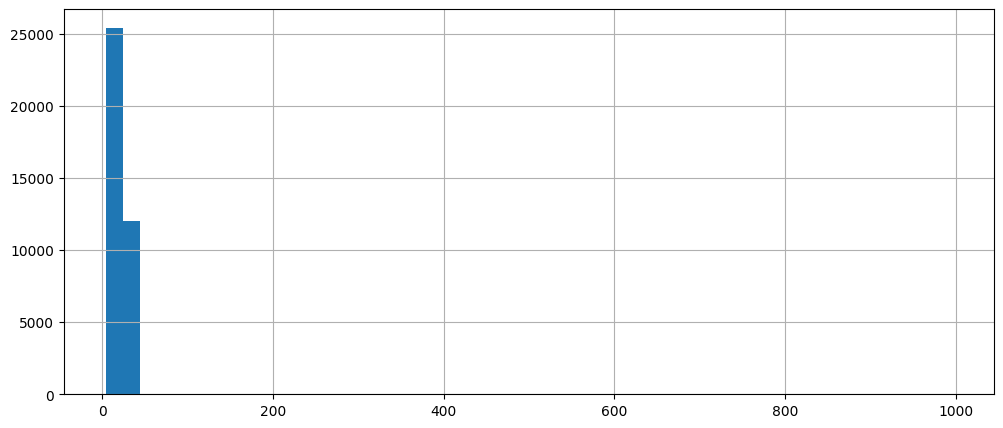

In [135]:
df['grossWeight'].hist(bins=50, figsize=(12, 5))

In [136]:
df.loc[df['grossWeight'] > 40, 'grossWeight'].count()

167

In [137]:
df.loc[df["grossWeight"] > 40, "grossWeight"] = np.nan

<Axes: >

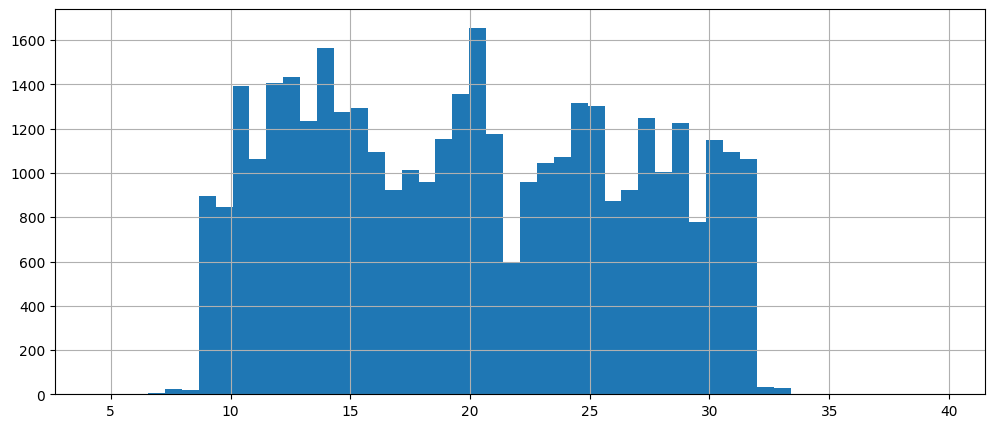

In [138]:
df['grossWeight'].hist(bins=50, figsize=(12, 5))

In [139]:
Test["grossWeight"] = Test["grossWeight"].apply(clean_weight)


Test.loc[Test["grossWeight"] > 40, "grossWeight"] = np.nan

## `netWeight` column  

In [140]:
df['netWeight'].isna().sum()

1223

In [141]:
def clean_net_weight(value):
    if pd.isna(value):
        return np.nan

    s = str(value).strip().lower()

    if s in ["not available", "nil", "?", "unknown", "to be determined", "tbd", "--", "###"]:
        return np.nan


    for prefix in ["data:", "val:", "amount:", "measure:"]:
        if s.startswith(prefix):
            s = s.replace(prefix, "").strip()


    match = re.findall(r"[-+]?\d*\.?\d+", s)
    if not match:
        return np.nan

    try:
        val = float(match[0])
    except:
        return np.nan


    if val <= 0:
        return np.nan


    if "kg" in s:
        return val
    elif "grams" in s or "g " in s or s.endswith("g"):
        return val / 1000
    elif "lbs" in s or "lb" in s:
        return val / 2.205
    elif "oz" in s:
        return val / 35.274
    else:
        return val

df["netWeight"] = df["netWeight"].apply(clean_net_weight)


In [142]:
df['netWeight'].isna().sum()

3530

<Axes: >

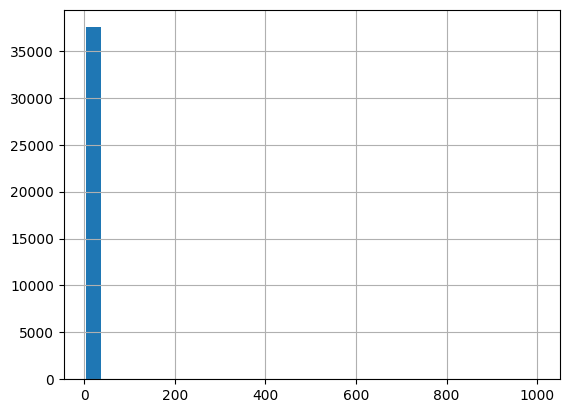

In [143]:
df["netWeight"].hist(bins=30)

In [144]:
df.loc[df["netWeight"] > 40, "netWeight"] = np.nan

<Axes: >

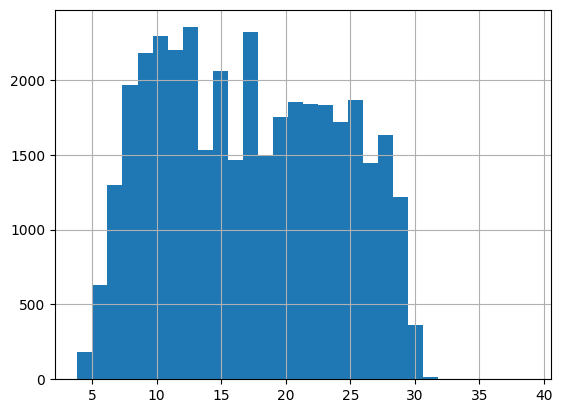

In [145]:
df["netWeight"].hist(bins=30)

In [146]:
Test["netWeight"] = Test["netWeight"].apply(clean_net_weight)



Test.loc[Test["netWeight"] > 40, "netWeight"] = np.nan

## `packageWeight` column

In [147]:
df['packageWeight'].isna().sum()

2201

In [148]:
def clean_package_weight(value):
    if pd.isna(value):
        return np.nan

    s = str(value).strip().lower()

    # Missing placeholders
    if s in ["nan", "val: nan", "amount: nan", "measure: nan", "data: nan", "unknown", "?", "--", "...", "nil"]:
        return np.nan

    # إزالة prefixes
    for prefix in ["val:", "amount:", "measure:", "data:"]:
        if s.startswith(prefix):
            s = s.replace(prefix, "").strip()

    # التعامل مع الوحدات
    try:
        if "kg" in s:
            return float(s.replace("kg", "").strip())
        elif "grams" in s:
            return float(s.replace("grams", "").strip()) / 1000
        elif "lbs" in s:
            return float(s.replace("lbs", "").strip()) * 0.453592
        elif "oz" in s:
            return float(s.replace("oz", "").strip()) * 0.0283495
        else:
            val = float(s)
            if val <= 0:
                return np.nan
            return val
    except:
        return np.nan


df["packageWeight"] = df["packageWeight"].apply(clean_package_weight)


In [149]:
df['packageWeight'].isna().sum()

4806

<Axes: >

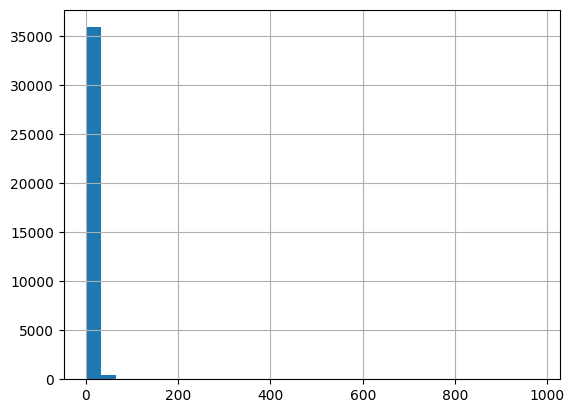

In [150]:
df['packageWeight'].hist(bins=30)

In [151]:
df.loc[df['packageWeight'] > 10, 'packageWeight'].count()


1053

In [152]:
df.loc[df["packageWeight"] > 10, "packageWeight"] = np.nan

<Axes: >

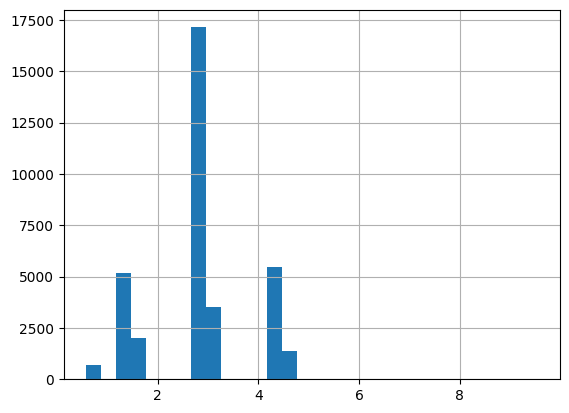

In [153]:
df['packageWeight'].hist(bins=30)

In [154]:
Test["packageWeight"] = Test["packageWeight"].apply(clean_package_weight)


Test.loc[Test["packageWeight"] > 10, "packageWeight"] = np.nan

## Filling the nan in the 3 columns ✅

In [155]:
df[["grossWeight", "netWeight", "packageWeight"]].isna().sum()

grossWeight      3711
netWeight        3703
packageWeight    5859
dtype: int64

In [156]:
cols = ["grossWeight", "netWeight", "packageWeight"]

imputer = knn(n_neighbors=5)
df[cols] = imputer.fit_transform(df[cols])

array([[<Axes: title={'center': 'grossWeight'}>,
        <Axes: title={'center': 'netWeight'}>],
       [<Axes: title={'center': 'packageWeight'}>, <Axes: >]],
      dtype=object)

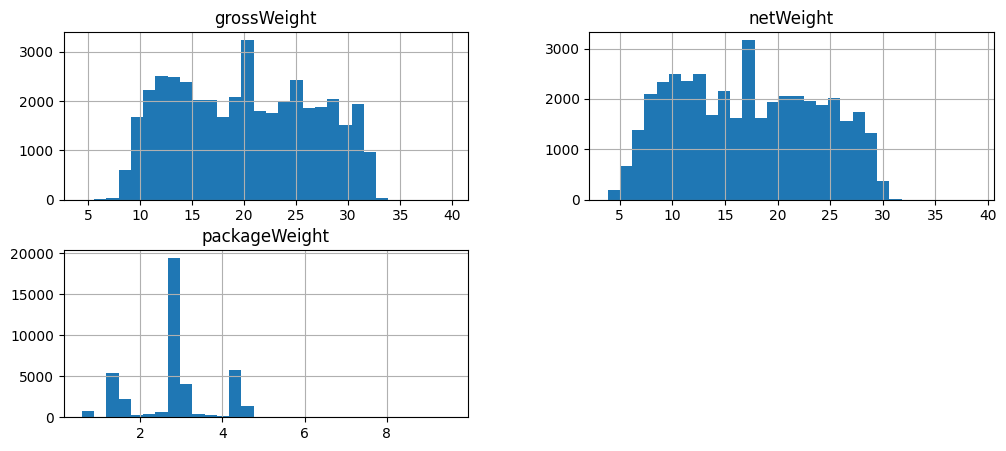

In [157]:
df[cols].hist(bins=30, figsize=(12, 5))

## Last Check

In [158]:
df.drop(columns=['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'], inplace=True)

In [159]:
df.isna().sum()

min.YearlyIncome             0
grossWeight                  0
netWeight                    0
isRecyclable?                0
storeKind                    0
storeSales                   0
storeCost                    0
groceryArea                  0
frozenArea                   0
meatArea                     0
cost                         0
customer_state               0
seller_state                 0
review_score                 0
totalArea                    0
packageWeight                0
item                         0
department                   0
order_brand                  0
count_additional_features    0
marital_status               0
gender                       0
promoCategory                0
dtype: int64

In [160]:
Test.drop(columns=['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'], inplace=True)

In [161]:
for col in Test.columns:
    if col in df.columns:
        if Test[col].dtype == df[col].dtype:
            print(f"✅ Column '{col}' has the SAME dtype: {df[col].dtype}")
        else:
            print(f"❌ Column '{col}' has DIFFERENT dtype: Test={Test[col].dtype}, df={df[col].dtype}")
    else:
        print(f"⚠️ Column '{col}' not found in df")


⚠️ Column 'ID' not found in df
✅ Column 'storeKind' has the SAME dtype: object
✅ Column 'storeSales' has the SAME dtype: float64
✅ Column 'storeCost' has the SAME dtype: float64
✅ Column 'grossWeight' has the SAME dtype: float64
✅ Column 'netWeight' has the SAME dtype: float64
✅ Column 'packageWeight' has the SAME dtype: float64
✅ Column 'isRecyclable?' has the SAME dtype: object
✅ Column 'min.YearlyIncome' has the SAME dtype: float64
✅ Column 'totalArea' has the SAME dtype: float64
✅ Column 'groceryArea' has the SAME dtype: float64
✅ Column 'frozenArea' has the SAME dtype: float64
✅ Column 'meatArea' has the SAME dtype: float64
✅ Column 'customer_state' has the SAME dtype: object
✅ Column 'seller_state' has the SAME dtype: object
✅ Column 'review_score' has the SAME dtype: float64
✅ Column 'item' has the SAME dtype: object
✅ Column 'department' has the SAME dtype: object
✅ Column 'order_brand' has the SAME dtype: object
✅ Column 'count_additional_features' has the SAME dtype: float64


In [162]:
assert len(Test.columns) == len(df.columns)

In [163]:
Test.isna().sum()

ID                              0
storeKind                    1346
storeSales                     64
storeCost                      59
grossWeight                  2948
netWeight                    3007
packageWeight                2033
isRecyclable?                  54
min.YearlyIncome               59
totalArea                    1047
groceryArea                  1100
frozenArea                   1029
meatArea                     1039
customer_state                277
seller_state                  273
review_score                  203
item                           63
department                     63
order_brand                    63
count_additional_features      26
marital_status                 59
gender                         59
promoCategory                  76
dtype: int64

In [164]:
df.to_csv("cleaned_train.csv",
          index=False,
          encoding='utf-8',
          na_rep='NA',
          float_format='%.6f')

In [165]:
Test.to_csv("cleaned_Test.csv",
          index=False,
          encoding='utf-8',
          na_rep='NA',
          float_format='%.6f')